# Model Design and Training
RSNA Intracranial Hemorrhage Detection
* Define and fine-tune neural network(s)
* Define training function
* Train model
* Tune hyperparameters

In [27]:
# Packages
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import pydicom
import PIL
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
import torch.optim as optim
import time
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from data_preprocessing import * # preprocessing script for this project

# Device
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
# Global paths
dpath = '/rsna-intracranial-hemorrhage-detection/'
trpath = '/rsna-intracranial-hemorrhage-detection/stage_2_train/'

# Randomness
random.seed(2021)
np.random.seed(2021)
torch.manual_seed(2021)

Import/design model(s)

In [28]:
dense121 = models.densenet121(pretrained=True)
num_ftrs = dense121.classifier.in_features
dense121.classifier = nn.Sequential(nn.Linear(num_ftrs, 6),
                                    nn.Sigmoid())
print(dense121)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) 

count_params(dense121)

# References:
    # DenseNet paper: https://arxiv.org/pdf/1608.06993.pdf
    # Finetuning pytorch models: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

6960006

Helper functions

In [29]:
##################################### Initialize weights function
def init_weights(m):
    if (type(m) == nn.Conv2d) | (type(m) == nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)
        
##################################### Loss and accuracy plot helpers
def plot_loss(loss_dict, title):
    train_loss = loss_dict['train']
    val_loss = loss_dict['validate']
    
    x = np.arange(len(train_loss))
    
    plt.figure(figsize=(10, 7))
    plt.plot(x, train_loss, label='Train Loss')
    plt.plot(x, val_loss, label='Validation Loss')
    
    plt.title(title, fontsize=18)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)

    plt.legend(fontsize=14)
    plt.savefig('./figs/train_loss_sub.png')
    plt.show()
    

def plot_acc(acc_dict, title):
    train_acc = acc_dict['train']
    val_acc = acc_dict['validate']
    
    x = np.arange(len(train_acc))
    
    plt.figure(figsize=(10, 7))
    plt.plot(x, train_acc, label='Train Accuracy')
    plt.plot(x, val_acc, label='Validation Accuracy')
    
    plt.title(title, fontsize=18)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)

    plt.legend(fontsize=14)
    plt.savefig('./figs/train_acc_sub.png')
    plt.show()

Training function

In [30]:
# Training function directly from HW2, need to update
def train_model(model, dataloader, optimizer, scheduler, loss_fn, threshold, num_epochs = 10, verbose = False):
    acc_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    auc_dict = {'train':[],'validate':[]}
    best_acc = 0
    best_auc = 0 
    phases = ['train','validate']
    since = time.time()
    for i in range(num_epochs):
        if verbose:
            print('Epoch: {}/{}'.format(i, num_epochs-1))
            print('-'*10)
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0

            preds_list = []
            labs_list = []

            if p == 'train':
                model.train()
            else:
                model.eval()
                
            for data in dataloader[p]:
                optimizer.zero_grad()
                image = data['image'].float().to(device)
                label = data['class'].float().to(device)
                output = model(image).to(device)
                loss = loss_fn(output, label).to(device)
                preds = torch.where(output > threshold, 1, 0)
                num_imgs = image.size()[0]
                running_correct += torch.sum(preds==label).item()
                running_loss += (loss.item()*num_imgs)
                running_total += num_imgs
                if p == 'train':
                    loss.backward()
                    optimizer.step()

                preds_list.extend(output.squeeze().tolist())
                labs_list.extend(label.squeeze().tolist())

            epoch_acc = float(running_correct/(running_total*6))
            epoch_loss = float(running_loss/running_total)
            preds = np.array(preds_list)
            labs = np.array(labs_list)
            epoch_auc = roc_auc_score(labs, preds)

            if verbose:
                print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f}'.format(p, epoch_loss, epoch_acc))
            
            acc_dict[p].append(epoch_acc)
            loss_dict[p].append(epoch_loss)
            auc_dict[p].append(epoch_auc) 
            if p == 'validate':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc

                if epoch_auc > best_auc:
                    best_auc = epoch_auc
                    best_model_wts = model.state_dict()

            else:
                if scheduler:
                    scheduler.step()

        # Save interim model
        MOD_PATH = './models/dense121_sub_{}.pt'.format(i)
        torch.save(best_model_wts, MOD_PATH)
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    print('Best val auc: {:4f}'.format(best_auc)) 
    
    model.load_state_dict(best_model_wts)
    
    return model, acc_dict, loss_dict, auc_dict, best_acc, best_auc

Dataloader

In [31]:
# Dataloader, subsets
train_df_path = './data/train_sub.csv'
val_df_path = './data/val_sub.csv'
test_df_path = './data/df_test.csv'
transformed_dataset = {'train':RSNADataset_3chan(train_df_path, trpath, transform=train_transform),
                       'validate':RSNADataset_3chan(val_df_path, trpath, transform=val_transform),
                       'test':RSNADataset_3chan(test_df_path, trpath, transform=val_transform),
                                          }
bs = 32

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                            shuffle=True, num_workers=0) for x in ['train', 'validate']}

dataloader['test'] = DataLoader(transformed_dataset['test'], batch_size=bs,
                                shuffle=False, num_workers=0)
data_sizes = {x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

Train model

In [32]:
# Train model
model = dense121.to(device)
# model.apply(init_weights)

loss_fn = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=.0001)

lambda_func = lambda epoch: 0.5 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)

# Maybe try plateau updates
# torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

dense121_trained, acc_dict, loss_dict, auc_dict, best_acc, best_auc = train_model(model,
                                                                                  dataloader,
                                                                                  optimizer,
                                                                                  scheduler,
                                                                                  loss_fn,
                                                                                  threshold=.6,
                                                                                  num_epochs=20,
                                                                                  verbose = True)

Epoch: 0/19
----------
Phase:train, epoch loss: 0.2469 Acc: 0.9403
Phase:validate, epoch loss: 0.1423 Acc: 0.9566
Epoch: 1/19
----------
Phase:train, epoch loss: 0.1287 Acc: 0.9561
Phase:validate, epoch loss: 0.1220 Acc: 0.9580
Epoch: 2/19
----------
Phase:train, epoch loss: 0.1138 Acc: 0.9597
Phase:validate, epoch loss: 0.1150 Acc: 0.9588
Epoch: 3/19
----------
Phase:train, epoch loss: 0.1064 Acc: 0.9602
Phase:validate, epoch loss: 0.1115 Acc: 0.9603
Epoch: 4/19
----------
Phase:train, epoch loss: 0.1020 Acc: 0.9621
Phase:validate, epoch loss: 0.1103 Acc: 0.9614
Epoch: 5/19
----------
Phase:train, epoch loss: 0.1001 Acc: 0.9626
Phase:validate, epoch loss: 0.1090 Acc: 0.9617
Epoch: 6/19
----------
Phase:train, epoch loss: 0.0988 Acc: 0.9628
Phase:validate, epoch loss: 0.1085 Acc: 0.9622
Epoch: 7/19
----------
Phase:train, epoch loss: 0.0981 Acc: 0.9637
Phase:validate, epoch loss: 0.1084 Acc: 0.9625
Epoch: 8/19
----------
Phase:train, epoch loss: 0.0986 Acc: 0.9640
Phase:validate, epoch

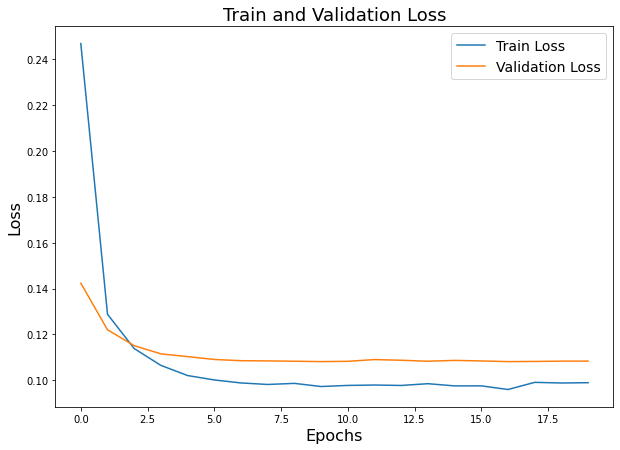

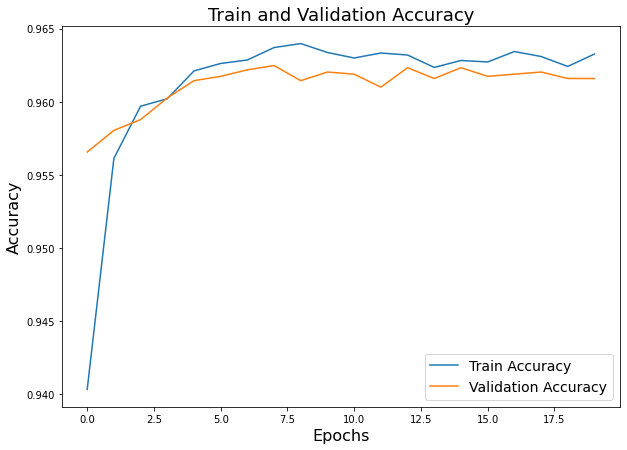

In [33]:
# Plot train and validation loss and accuracy per epoch
plot_loss(loss_dict, 'Train and Validation Loss')

plot_acc(acc_dict, 'Train and Validation Accuracy')

Save best model

In [34]:
MOD_PATH = './models/dense121_sub.pt'
torch.save(dense121_trained, MOD_PATH)

Tune hyperparameters

In [35]:
# def test_hypers(bs, set_lr, threshold, set_epochs):
#     # Train model
#     dense121 = models.densenet121(pretrained=True)
#     num_ftrs = dense121.classifier.in_features
#     dense121.classifier = nn.Sequential(nn.Linear(num_ftrs, 6),
#                                         nn.Sigmoid())
    
#     model = dense121.to(device)
#     # model.apply(init_weights)

#     loss_fn = nn.BCELoss()
#     optimizer = optim.Adam(model.parameters(), lr=set_lr)

#     lambda_func = lambda epoch: 0.5 ** epoch
#     scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)

#     h_model, acc_dict, loss_dict, auc_dict, best_acc, best_auc = train_model(model,
#                                                                              dataloader,
#                                                                              optimizer,
#                                                                              scheduler,
#                                                                              loss_fn,
#                                                                              threshold=threshold,
#                                                                              num_epochs=20,
#                                                                              verbose = False)
#     return best_acc, best_auc

# print('--------------------------------------------------------------')
# print('Test Hyperparameters')
# print('--------------------------------------------------------------')

# print('Learning Rate')
# # Learning rate
# best_acc = 0
# best_auc = 0
# best_lr = 0
# for lr in [0.01, 0.001, 0.0001, 0.00001]:
#     acc, auc = test_hypers(bs, lr, .7, 20)
#     print('Learning rate: {}'.format(lr), 'Accuracy: {}'.format(acc), 'AUC: {}'.format(auc))
#     if auc > best_auc:
#         best_auc = auc
#         best_lr = lr
# print('Best learn rate: {}'.format(best_lr), 'AUC: {}'.format(best_auc))

# print('--------------------------------------------------------------')

# print('Threshold')
# # Threshold
# best_acc = 0
# best_auc = 0
# best_t = 0
# for t in [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9]:
#     acc, auc = test_hypers(bs, best_lr, t, 20)
#     print('Threshold: {}'.format(t), 'Accuracy: {}'.format(acc), 'AUC: {}'.format(auc)) 
#     if auc > best_auc:
#         best_auc = auc
#         best_t = t
# print('Best threshold: {}'.format(best_t), 'AUC: {}'.format(best_auc))